# Activity Satisfaction Predictor

## Import dependencies

In [201]:
# CHANGES
# - look at the distributions of features and log or square root the ones that are skewed, have a tail on the right
# – use RBFs for multimodal distributions
# – instead of doing one hot encoding, simply number weekday 1-7
# – use activity name as a vector embedding with a neural net
# – combine all transformations into a pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin

## Store data in a pd.DataFrame() and get basic info about the data

In [202]:
df_orig = pd.read_csv('activity-satisfaction-form.csv')

In [203]:
column_names = ['Timestamp', 'Name', 'Activity', 'Date', 'Time', 
                'Weekday', 'Social context', 'Location', 'Duration',
                'Cost', 'Mental effort', 'Physical effort', 'Creativity level',
                'Focus level', 'Autonomy', 'Social inter qlt', 'Productivity', 
                'Enjoyment', 'Fulfillment', 'Satisfaction']

df_orig.columns = column_names
df_orig.loc[df_orig['Location'] == 'School / University', 'Location'] = 'School or university'
df = df_orig.copy()

In [204]:
df.head()

,Timestamp,Name,Activity,Date,Time,Weekday,Social context,Location,Duration,Cost,Mental effort,Physical effort,Creativity level,Focus level,Autonomy,Social inter qlt,Productivity,Enjoyment,Fulfillment,Satisfaction
0,2025/10/30 11:34:03 AM GMT,NaN,Gym workout,2025-10-30,10:00,Thursday,Alone,Gym,60,£5,3,9,NaN,4.0,Self-initiated,NaN,7.0,7,9,8
1,2025/10/30 9:29:58 PM GMT,Mikhail,Making math notes,2025-10-30,12:00,Thursday,Alone,Home,120,0,7,1,3.0,7.0,Self-initiated,NaN,6.0,3,8,5
2,2025/10/30 10:05:23 PM GMT,Mikhail,Reading machine learning book,2025-10-30,16:00,Thursday,Alone,Home,45,0,9,1,4.0,8.0,Self-initiated,NaN,9.0,7,9,9
3,2025/10/30 10:07:29 PM GMT,Mikhail,Playing a video games,2025-10-30,18:00,Thursday,Alone,Home,60,0,2,1,4.0,4.0,Self-initiated,NaN,NaN,9,3,6
4,2025/10/30 10:11:51 PM GMT,Mikhail,Picking up girlfriend after work,2025-10-30,19:30,Thursday,Partner,Outdoors,60,0,2,5,NaN,NaN,Self-initiated,8.0,NaN,10,10,10


Notice the target variables *Enjoyment*, *Fulfillment*, and *Satisfaction*:

- The minimum values for the three columns are 3, 2, and 4, which is quite high;

- The median is at 7.5, 8.5, and 8, which is a strong indicator the data lacks examples on the lower end;

- Keep in mind: it may be beneficial to collect more examples with lower 
target variable values for a rich variety of predictions

In [205]:
df.describe()

,Mental effort,Physical effort,Creativity level,Focus level,Social inter qlt,Productivity,Enjoyment,Fulfillment,Satisfaction
count,44.000000,44.000000,20.000000,20.000000,26.000000,24.000000,44.00000,44.000000,44.000000
mean,3.886364,3.000000,3.950000,6.500000,6.269231,6.750000,7.25000,7.568182,7.477273
std,2.704139,2.057318,1.820208,1.849609,2.569945,1.594829,2.42204,2.214096,2.085260
min,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000,3.00000,2.000000,3.000000
25%,2.000000,1.000000,3.000000,5.000000,4.250000,5.750000,5.75000,6.750000,6.000000
50%,2.500000,2.500000,4.000000,7.000000,7.000000,7.000000,7.00000,8.000000,8.000000
75%,6.000000,4.000000,5.250000,8.000000,8.000000,8.000000,9.25000,9.000000,9.000000
max,10.000000,9.000000,7.000000,10.000000,10.000000,9.000000,10.00000,10.000000,10.000000


[]

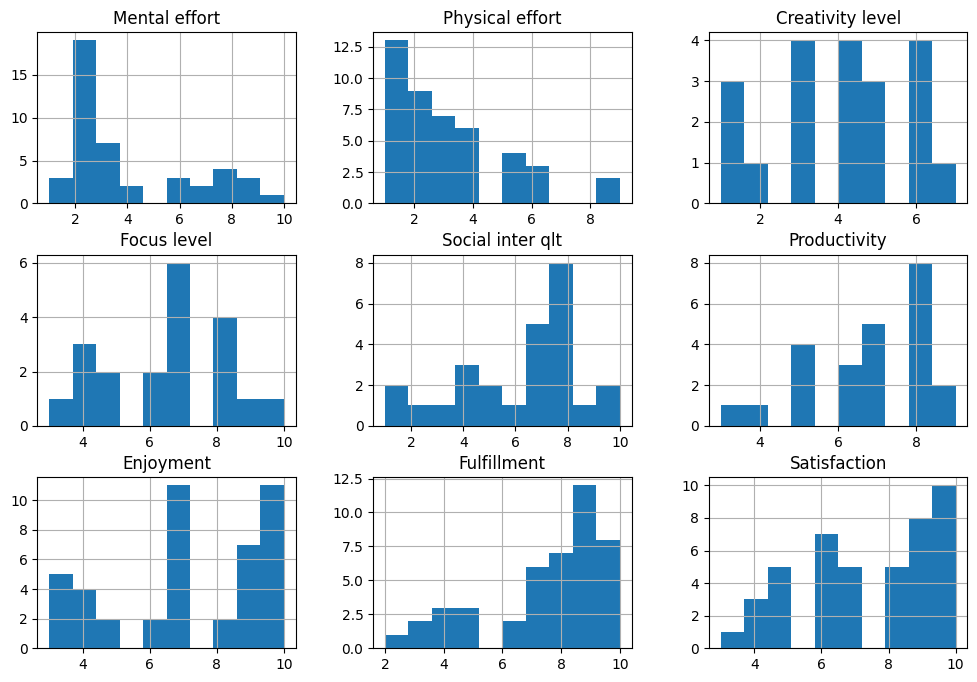

In [206]:
df.hist(bins=10, figsize=(12, 8))
plt.plot()

## Split the data into a training and a testing set

In [207]:
from zlib import crc32

def is_id_in_hash_set(identifier, test_ratio):
    return crc32(np.int32(identifier).tobytes()) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_col):
    ids = data[id_col]
    in_test_set = ids.apply(lambda id_: is_id_in_hash_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [208]:
ids = [
    ''.join([i for i in date if i.isdigit()]) + ('1' if 'PM' in date else '0')
    for date in df['Timestamp'].values
]

df['id'] = pd.to_datetime(df['Timestamp'], utc=True).astype(np.int64) // 10**9

In [209]:
df = df.drop(['Timestamp', 'Activity', 'Name', 'Date'], axis=1, errors='ignore')

In [210]:
train_set, test_set = split_data_with_id_hash(df, 0.2, 'id')

## Data exploration

In [211]:
activities = train_set.drop(['Enjoyment', 'Fulfillment', 'Satisfaction'], axis=1)
activities_labels = train_set['Satisfaction'].copy()

In [212]:
duration_min = activities['Duration'].str.extract(r'([0-9.]+)')[0].astype(float)
cost_pound = activities['Cost'].str.extract(r'([0-9.]+)')[0].astype(float)
cost_per_min = cost_pound / duration_min

In [213]:
activities_corr = train_set.copy()
activities_corr['Duration (min)'] = duration_min
activities_corr['Cost (pound)'] = cost_pound
activities_corr['Cost per min'] = cost_per_min

In [214]:
corr_matrix = activities_corr.corr(numeric_only=True)
corr_matrix['Satisfaction'].sort_values(ascending=False)

Satisfaction        1.000000
Enjoyment           0.877937
Social inter qlt    0.733696
Fulfillment         0.647054
Cost (pound)        0.410927
Productivity        0.375736
Creativity level    0.351556
Physical effort     0.349334
Focus level         0.336491
Cost per min        0.274999
Duration (min)     -0.006228
id                 -0.156483
Mental effort      -0.339139
Name: Satisfaction, dtype: float64

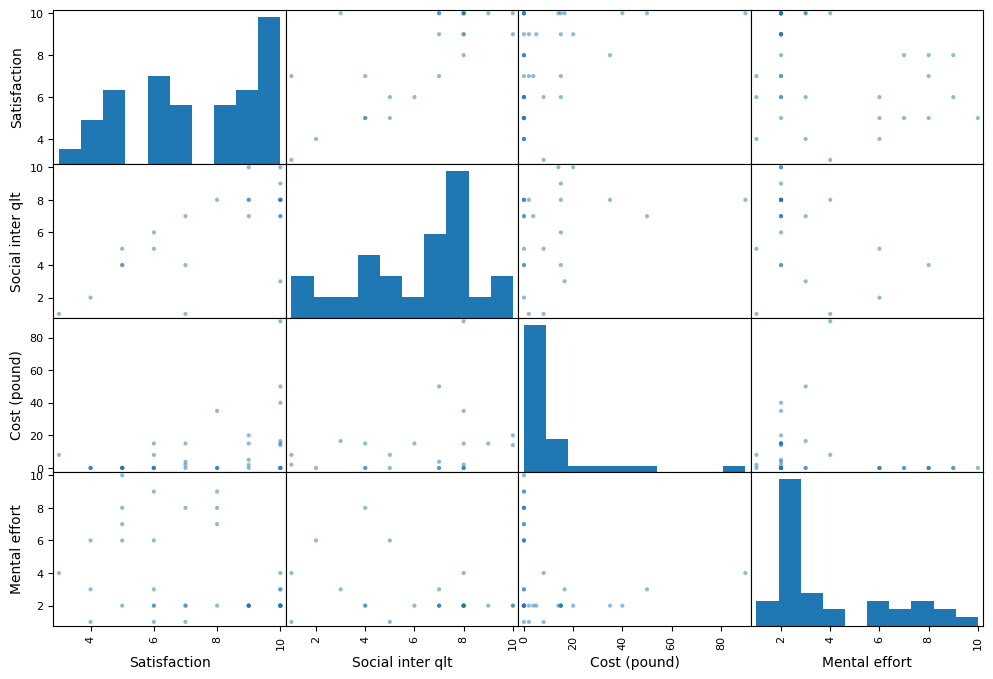

In [215]:
corr_features = ['Satisfaction', 'Social inter qlt', 'Cost (pound)', 'Mental effort']
scatter_matrix(activities_corr[corr_features], figsize=(12, 8))
plt.show()

## Data preprocessing tasks:

- Replace NaN values in *Name, Creativity level, Focus level, Social inter qlt, Productivity*

- Encode (*Date*) and *Time* cyclically

- Encode categorical features

- Perform feature scaling / standardisation on numerical features

In [216]:
def transform_cyclical_data(X):
    if isinstance(X, pd.DataFrame):
        X = X.iloc[:, 0]
    elif isinstance(X, np.ndarray):
        X = pd.Series(X[:, 0])

    hours = X.str.slice(0, 2, 1).astype(int)
    mins = X.str.slice(3, 5, 1).astype(int)

    hours_sin = np.sin(2*np.pi*(hours / 24))
    hours_cos = np.cos(2*np.pi*(hours / 24))
    mins_sin = np.sin(2*np.pi*(mins / 60))
    mins_cos = np.cos(2*np.pi*(mins / 60))

    return np.c_[hours_sin, hours_cos, mins_sin, mins_cos]

def cyclical_name(function_transformer, feature_names_in):
    return ['hours_sin', 'hours_cos', 'mins_sin', 'mins_cos']

In [217]:
def transform_duration_to_mins(X): # convert duration from hours to mins
    if isinstance(X, pd.DataFrame):
        X = X.iloc[:, 0].astype(str)
    elif isinstance(X, pd.Series):
        X = X.astype(str)
    elif isinstance(X, np.ndarray):
        X = pd.Series(X[:, 0].astype(str))
    
    num = X.str.extract(r'([0-9.]+)')[0].astype(float)
    is_hr = X.str.contains(r'[^0-9.]', na=False)
    num.loc[is_hr] *= 60
    return num.to_numpy().reshape(-1, 1)

def duration_name(function_transformer, feature_names_in):
    return ['duration_min']

In [218]:
def transform_cost_to_pounds(X):
    if isinstance(X, pd.DataFrame):
        X = X.iloc[:, 0].astype(str)
    elif isinstance(X, pd.Series):
        X = X.astype(str)
    elif isinstance(X, np.ndarray):
        X = pd.Series(X[:, 0].astype(str))
    
    num = X.str.extract(r'([0-9.]+)')[0].astype(float)
    is_eur = X.str.contains('EUR', case=False, na=False)
    num.loc[is_eur] *= 0.88
    return num.to_numpy().reshape(-1, 1)

def cost_name(function_transformer, feature_names_in):
    return ['cost_pound']

In [219]:
def ratio_name(function_transformer, feature_names_in):
  return ['ratio']

def compute_ratio(X):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    
    x1 = X[:, 0]
    x2 = X[:, 1]
    x2_safe = np.where(x2 == 0, 1e-6, x2)
    return (x1 / x2_safe).reshape(-1, 1)

ratio_transformer = make_pipeline(FunctionTransformer(compute_ratio, feature_names_out=ratio_name))

In [220]:
def ordinal_name(function_transformer, feature_names_in):
    return ['Weekday']

In [221]:
one_hot_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    FunctionTransformer(lambda X: X.to_numpy() if hasattr(X, 'to_numpy') else X, feature_names_out=ordinal_name),
    OrdinalEncoder(categories=[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                'Friday', 'Saturday', 'Sunday']])
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, feature_names_out='one-to-one'),
    StandardScaler()
)

cyclical_pipeline = make_pipeline(
    FunctionTransformer(transform_cyclical_data, feature_names_out=cyclical_name)
)

duration_parse_pipeline = make_pipeline(
    FunctionTransformer(transform_duration_to_mins, feature_names_out=duration_name)
)
duration_scale_pipeline = Pipeline([
    ('parse', duration_parse_pipeline),
    ('scale', StandardScaler())
])

cost_parse_pipeline = make_pipeline(
    FunctionTransformer(transform_cost_to_pounds, feature_names_out=cost_name)
)
cost_scale_pipeline = Pipeline([
    ('parse', cost_parse_pipeline),
    ('log', log_pipeline)
])

default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                     StandardScaler())

ratio_pipeline = Pipeline([
    ('parse', ColumnTransformer([
        ('cost', cost_parse_pipeline, ['Cost']),
        ('duration', duration_parse_pipeline, ['Duration'])
    ])),
    ('ratio', ratio_transformer),
    ('scale', StandardScaler())
])

In [222]:
preprocessing = ColumnTransformer([
    ('one-hot', one_hot_pipeline, ['Social context', 'Location', 'Autonomy']),
    ('ordinal', ordinal_pipeline, ['Weekday']),
    ('log', log_pipeline, ['Physical effort', 'Mental effort']),
    ('cyclical', cyclical_pipeline, ['Time']),
    ('duration', duration_scale_pipeline, ['Duration']),
    ('cost', cost_scale_pipeline, ['Cost']),
    ('cost_per_min', ratio_pipeline, ['Cost', 'Duration'])
], remainder=default_num_pipeline, verbose=True)

In [223]:
activ_prepared = preprocessing.fit_transform(activities)
preprocessing.get_feature_names_out()

[ColumnTransformer] ....... (1 of 8) Processing one-hot, total=   0.0s
[ColumnTransformer] ....... (2 of 8) Processing ordinal, total=   0.0s
[ColumnTransformer] ........... (3 of 8) Processing log, total=   0.0s
[ColumnTransformer] ...... (4 of 8) Processing cyclical, total=   0.0s
[ColumnTransformer] ...... (5 of 8) Processing duration, total=   0.0s
[ColumnTransformer] .......... (6 of 8) Processing cost, total=   0.2s
[ColumnTransformer] .. (7 of 8) Processing cost_per_min, total=   0.1s
[ColumnTransformer] ..... (8 of 8) Processing remainder, total=   0.1s


array(['one-hot__Social context_Alone', 'one-hot__Social context_Class',
       'one-hot__Social context_Classmates',
       'one-hot__Social context_Family',
       'one-hot__Social context_Friends',
       'one-hot__Social context_Partner', 'one-hot__Location_Bowling ',
       'one-hot__Location_Cinema', 'one-hot__Location_Concert venue',
       'one-hot__Location_Home', 'one-hot__Location_Mall',
       'one-hot__Location_Outdoors', 'one-hot__Location_Restaurant',
       'one-hot__Location_School or university',
       'one-hot__Location_cinema', 'one-hot__Autonomy_Obligatory',
       'one-hot__Autonomy_Self-initiated', 'ordinal__Weekday',
       'log__Physical effort', 'log__Mental effort',
       'cyclical__hours_sin', 'cyclical__hours_cos', 'cyclical__mins_sin',
       'cyclical__mins_cos', 'duration__duration_min', 'cost__cost_pound',
       'cost_per_min__ratio', 'remainder__Creativity level',
       'remainder__Focus level', 'remainder__Social inter qlt',
       'remainder__Pro